# Pylops-distributed - Solvers

In this notebook we investigate the use of pylops-distributed CG and CGLS solvers with distributed operators.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse.linalg.interface import MatrixLinearOperator, aslinearoperator 
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr, gmres
from scipy.signal import convolve, filtfilt
from dask.distributed import performance_report

In [2]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=1, n_workers=4)
client

Client Scheduler: inproc://10.0.0.156/3852/1 Dashboard: http://10.0.0.156:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### CG for square systems

Let's just try out the solver with a matrix 

eigs [1.40915640e+02 1.23483320e+02 1.15751612e+02 1.09010781e+02
 9.08256000e+01 8.84139287e+01 8.49593751e+01 7.77661808e+01
 7.62261030e+01 6.57976596e+01 5.93522575e+01 5.54187091e+01
 5.19310520e+01 4.84624657e+01 4.50222991e+01 4.31437028e+01
 3.91054773e+01 3.59360315e+01 3.36481017e+01 2.86192343e+01
 2.65111081e+01 2.19851755e+01 2.00639186e+01 1.75290492e+01
 1.65609945e+01 1.42031371e+01 1.32386635e+01 1.07937980e+01
 9.20401543e+00 7.77064048e+00 4.51521148e+00 3.88061301e+00
 2.58533338e+00 1.90878406e+00 1.35536229e+00 9.47319106e-01
 4.89201581e-01 5.52959134e-02 1.17057847e-01 2.06406408e-01]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


(0.9, 1.1)

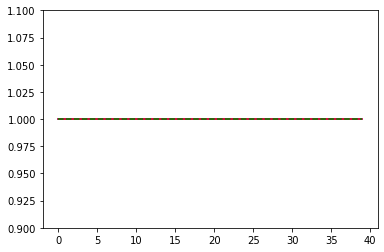

In [3]:
n = 40
niter = n * 2
x = np.ones(n)

A = np.random.randn(n, n)
A = np.dot(A.T, A)
print('eigs', np.linalg.eig(A)[0])

Aop = MatrixLinearOperator(A)
#Aop = aslinearoperator(A)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, tol=0, maxiter=niter)[0]
xinv = pylops_distributed.optimization.cg.cg(Aop, y, np.zeros_like(x), tol=0, niter=niter)[0]
print(xinv_sp)
print(xinv)

plt.figure()
plt.plot(x,'b', xinv_sp,'r', xinv, '--g')
plt.ylim(0.9, 1.1)

And with the LinearOperator

In [4]:
Ada = da.from_array(A, chunks=(n//2, n))
Adaop = pylops_distributed.MatrixMult(Ada, compute=(False, False))

y = Aop * np.ones(n)
yy = Adaop * da.ones(n, chunks=(n//2,))

xinv_sp = cg(Aop, yy, maxiter=n)[0]
xinv = pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter)[0]
xinv1 = pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0]

print(xinv_sp)
print(xinv)
print(xinv.compute())
print(xinv1.compute())

[0.94033047 1.00733541 1.02155122 1.03570144 0.97204653 0.96998104
 0.92759964 1.01767323 0.98687269 0.97509681 1.02688219 1.00587473
 0.91358055 0.93297877 1.02068345 1.01352795 1.03423851 0.96062992
 1.02038245 1.0035857  0.977226   1.05548331 0.99029724 0.99189707
 1.03276037 0.97920542 1.08121494 0.99698102 0.96226755 0.97463722
 0.9759277  1.03736988 0.97152664 1.06127016 0.98358446 1.03304261
 0.97594625 0.98662887 0.97912944 1.00223848]
dask.array<add, shape=(40,), dtype=float64, chunksize=(20,), chunktype=numpy.ndarray>
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
%timeit -n 3 -r 1 cg(Aop, y, maxiter=n)[0]
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, y, da.zeros(n), tol=0, niter=niter)[0].compute()
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, compute=True)[0]
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0].compute()

2.41 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
8.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
15.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
9.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [7]:
with performance_report(filename="/Users/matteoravasi/Desktop/dask-report-cg_postponed.html"):
    pylops_distributed.optimization.cg.cg(Adaop, y, da.zeros(n), tol=0, niter=niter)[0].compute()

In [8]:
with performance_report(filename="/Users/matteoravasi/Desktop/dask-report-cg_compute.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, compute=True)[0]

In [9]:
with performance_report(filename="/Users/matteoravasi/Desktop/dask-report-cg_persist.html"):
    pylops_distributed.optimization.cg.cg(Adaop, yy, da.zeros(n), tol=0, niter=niter, client=client)[0].compute()

### CGLS for rectangular systems

In [10]:
n, m = 100, 6
x = np.ones(m)

A = np.random.randn(n, m)
Ada = da.from_array(A, chunks=(n//2, m), name='Aop')
Aop = pylops_distributed.MatrixMult(Ada, compute=(False, False))
y = Aop * da.ones(m, name='x')

xinv = pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m, name='x0'), m)[0]

In [11]:
#y.visualize(rankdir="LR")
#xinv.visualize(rankdir="LR")

In [12]:
print(xinv.compute())

[1. 1. 1. 1. 1. 1.]


In [13]:
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20)[0].compute()
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20, compute=True)
%timeit -n 3 -r 1 pylops_distributed.optimization.cg.cgls(Aop, y, da.zeros(m), tol=0, niter=20, client=client)[0].compute()

2.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
2.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
2.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)
